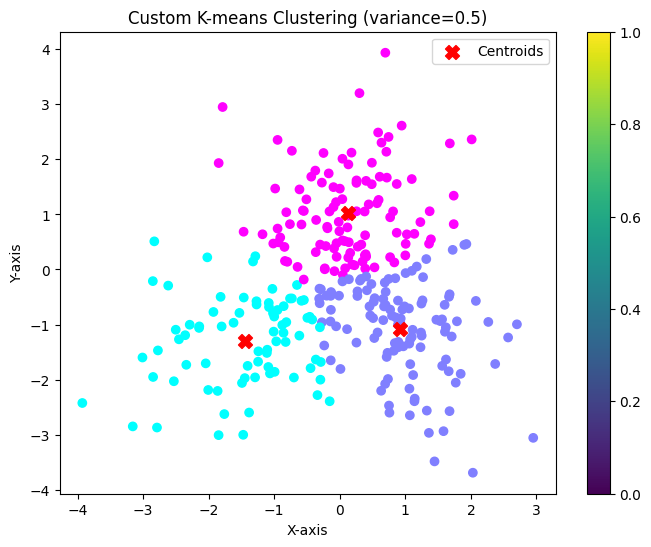

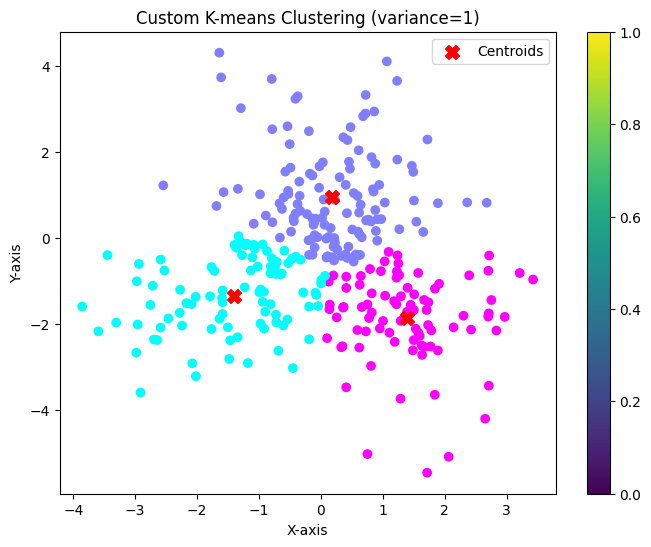

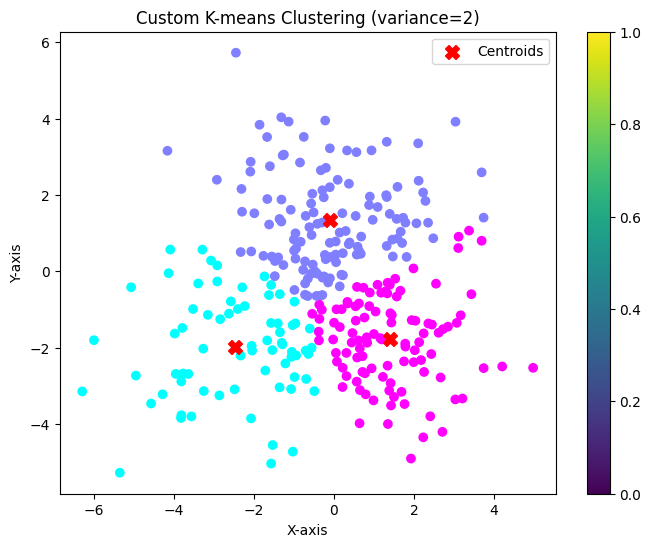

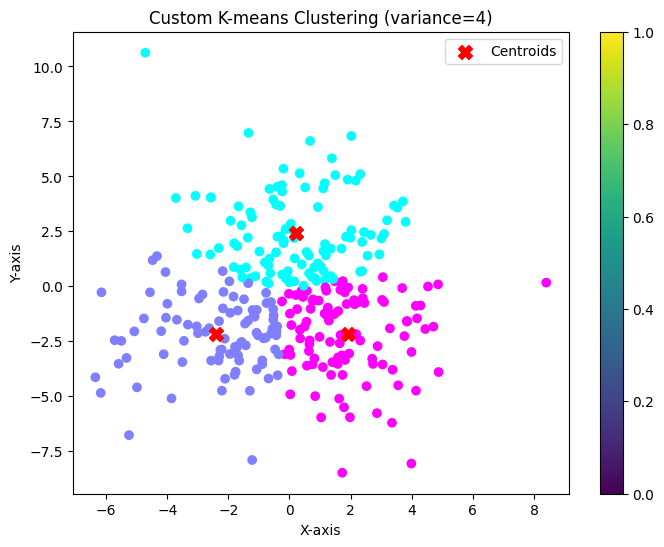

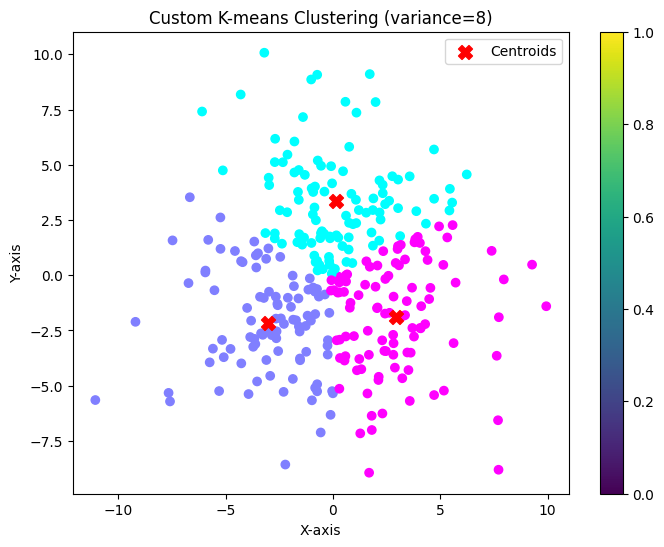

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from scipy.stats import multivariate_normal
from random import randrange
# Function to generate custom synthetic data
def create_custom_synthetic_data(var, num_samples):

    # Distribution A
    mu_a = np.array([-1, -1])
    cov_a = var * np.array([[2, 0.5], [0.5, 1]])
    x_a, y_a = np.random.multivariate_normal(mu_a, cov_a, num_samples).T

    # Distribution B
    mu_b = np.array([1, -1])
    cov_b = var * np.array([[1, -0.5], [-0.5, 2]])
    x_b, y_b = np.random.multivariate_normal(mu_b, cov_b, num_samples).T

    # Distribution C
    mu_c = np.array([0, 1])
    cov_c = var * np.array([[1, 0], [0, 2]])
    x_c, y_c = np.random.multivariate_normal(mu_c, cov_c, num_samples).T

    x = np.concatenate((x_a, np.concatenate((x_b, x_c), axis=0)), axis=0)
    y = np.concatenate((y_a, np.concatenate((y_b, y_c), axis=0)), axis=0)

    return np.vstack((x, y)).T

# Implement custom K-means clustering
def custom_kmeans_clustering(data, k, max_iterations=10000):
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]
    for _ in range(max_iterations):
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids
    return labels


def kmeans_objective(data, centroids, labels):
    distances = np.linalg.norm(data - centroids[labels], axis=1)
    return np.sum(distances**2)

def evaluate_custom_clustering_accuracy(true_labels, predicted_labels):
    mapping = {}
    for i in range(len(true_labels)):
        if len(predicted_labels[true_labels == i]) > 0:
            mapping[i] = np.argmax(np.bincount(predicted_labels[true_labels == i]))

    mapped_labels = [mapping[label] for label in predicted_labels if label in mapping]
    accuracy = accuracy_score(true_labels, mapped_labels)
    return accuracy

def plot_custom_clusters_kc(data, labels, centroids, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='cool')
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, marker='X', label='Centroids')
    plt.title(title)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.colorbar()
    plt.legend()
    plt.show()


variance_values = [0.5, 1, 2, 4, 8]
#variance_values = [0.5, 8]
custom_datasets = [create_custom_synthetic_data(var, 100) for var in variance_values]

kmeans_objectives = []
gmm_objectives = []
kmeans_accuracies = []
gmm_accuracies = []

for i, var in enumerate(variance_values):
    data = custom_datasets[i]
    true_labels = np.repeat(np.arange(3), 100)

    custom_kmeans_labels = custom_kmeans_clustering(data, 3)
    custom_kmeans_accuracy = evaluate_custom_clustering_accuracy(true_labels, custom_kmeans_labels)
    centroids_kmeans = np.array([data[custom_kmeans_labels == j].mean(axis=0) for j in range(3)])
    kmeans_objective_value = kmeans_objective(data, centroids_kmeans, custom_kmeans_labels)
    kmeans_objectives.append(kmeans_objective_value)
    kmeans_accuracies.append(custom_kmeans_accuracy)


    plot_custom_clusters_kc(data, custom_kmeans_labels, centroids_kmeans, f'Custom K-means Clustering (variance={var})')






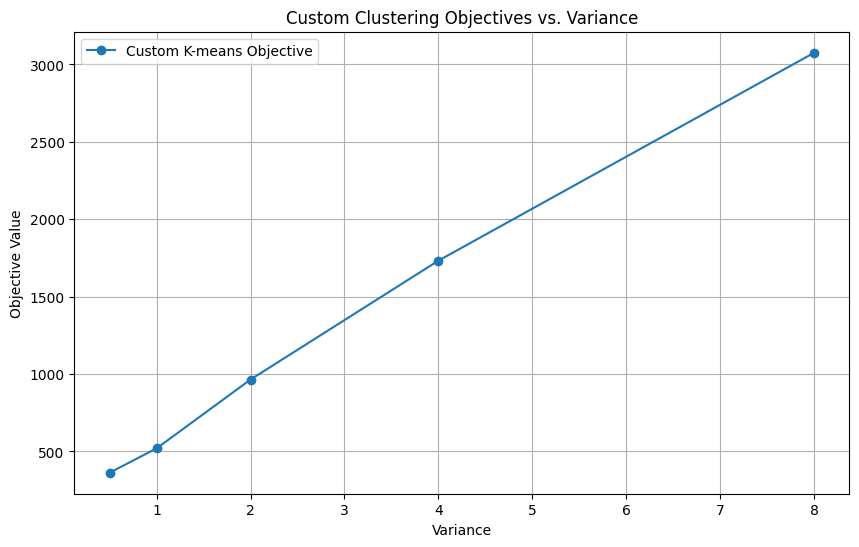

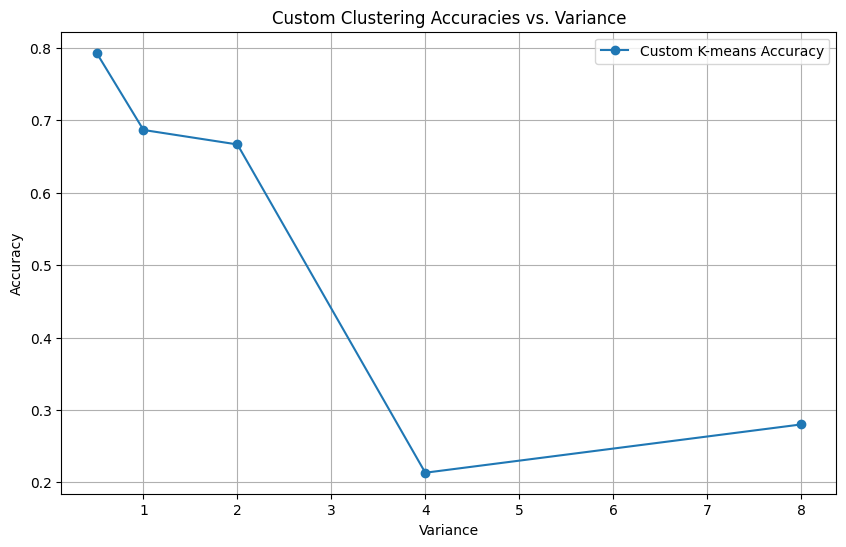

In [70]:
# Plot clustering objectives against variance values
plt.figure(figsize=(10, 6))
plt.plot(variance_values, kmeans_objectives, marker='o', label='Custom K-means Objective')
plt.title('Custom Clustering Objectives vs. Variance')
plt.xlabel('Variance')
plt.ylabel('Objective Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot clustering accuracies against variance values
plt.figure(figsize=(10, 6))
plt.plot(variance_values, kmeans_accuracies, marker='o', label='Custom K-means Accuracy')
plt.title('Custom Clustering Accuracies vs. Variance')
plt.xlabel('Variance')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [50]:
class GaussianMixtureModel():
    def __init__(self, max_iterations, tolerance):
        self.log_likelihood = None
        self.means = None
        self.covariances = None
        self.weights = None
        self.probabilities = None
        self.has_converged = False
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.feature_1 = None
        self.feature_2 = None
        self.num_clusters = None


    def _update_parameters(self):
        self.weights = np.sum(self.probabilities, axis=0) / len(self.feature_2)
        self.means = np.dot(self.probabilities.T, np.vstack((self.feature_1, self.feature_2)).T) / np.vstack(np.sum(self.probabilities, axis=0))
        for i in range(self.num_clusters):
            dist = np.vstack((self.feature_1, self.feature_2)).T - self.means[i]
            self.covariances[i] = np.dot(self.probabilities[:, i] * dist.T, dist) / np.sum(self.probabilities, axis=0)[i]

    def _update_probabilities(self):
        for i in range(self.num_clusters):
            likelihood = multivariate_normal(self.means[i], self.covariances[i]).pdf(np.vstack((self.feature_1, self.feature_2)).T)
            self.probabilities[:, i] = self.weights[i] * likelihood
        self.probabilities = self.probabilities / np.sum(self.probabilities, axis=1, keepdims=True)

    def _log_likelihood(self):
        weight_likelihood = np.zeros((len(self.feature_1), self.num_clusters))
        for i in range(self.num_clusters):
            likelihood = multivariate_normal(self.means[i], self.covariances[i]).pdf(np.vstack((self.feature_1, self.feature_2)).T)
            weight_likelihood[:, i] = self.weights[i] * likelihood
        self.log_likelihood = -np.sum(np.log(np.sum(weight_likelihood, axis=1)))
        return self.log_likelihood

    def cluster(self, num_clusters, feature_1, feature_2):
        self.feature_1 = feature_1
        self.feature_2 = feature_2
        self.num_clusters = num_clusters

        idx = randrange(len(feature_1))
        means = [[feature_1[idx], feature_2[idx]]]
        means.extend([
            [feature_1[idx_mu], feature_2[idx_mu]]
            for idx_mu in [
                min(
                    range(len(feature_1)),
                    key=lambda j: min(
                        (feature_1[j] - mu[0])**2 + (feature_2[j] - mu[1])**2
                        for mu in means
                    )
                )
                for _ in range(2, num_clusters + 1)
            ]
        ])
        self.means = means

        cov = np.cov(np.vstack((feature_1, feature_2)).T, rowvar=False)
        self.covariances = [cov for _ in range(num_clusters)]

        self.weights = [1 / num_clusters] * num_clusters

        self.probabilities = [[1 / num_clusters] * num_clusters for _ in range(len(feature_1))]

        prev_log_likelihood, new_log_likelihood = 0, 0
        for i in range(self.max_iterations):
            self._update_probabilities()
            self._update_parameters()
            new_log_likelihood = self._log_likelihood()
            delta_log_likelihood = prev_log_likelihood - new_log_likelihood
            if abs(delta_log_likelihood) <= self.tolerance:
                self.has_converged = True
                break
            prev_log_likelihood = new_log_likelihood


    def get_means(self):
        return self.means

    def get_covariances(self):
        return self.covariances

    def get_objective_value(self):
        return self.log_likelihood

    def calculate_accuracy(self, true_labels):
      closest_centroids = []  # List to store the index of the closest centroid for each data point

      # Calculate the squared Euclidean distance for each data point to each centroid
      for i in range(self.num_clusters):
          distances = []  # List to store distances for each centroid
          for mu in self.means:
              # Calculate squared Euclidean distance
              distance = (np.mean(self.feature_1[i * 100:(i + 1) * 100]) - mu[0]) ** 2 + (np.mean(self.feature_2[i * 100:(i + 1) * 100]) - mu[1]) ** 2
              distances.append(distance)
          closest_centroids.append(np.argmin(distances))  # Append index of closest centroid

      predicted_clusters = np.argmax(self.probabilities, axis=1)  # Get the predicted cluster for each data point
      cluster_names = ['a', 'b', 'c']  # Names for the clusters

      # Map the cluster labels to the original labels based on closest centroids
      for i in range(self.num_clusters):
          cluster_name = cluster_names[i]
          predicted_clusters = [(j, cluster_name)[j == closest_centroids[i]] for j in predicted_clusters]

      # Calculate accuracy by comparing predicted labels with true labels
      correct_predictions = sum(x == y for x, y in zip(predicted_clusters, true_labels))
      accuracy = correct_predictions / len(true_labels)

      return accuracy


    def get_termination_status(self):
        return self.has_converged

    def get_probabilities(self):
        return self.probabilities

    def get_weights(self):
        return self.weights


<ipython-input-50-6af8d7469792>:91: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  predicted_dist = [(j, letter)[j == proba_dist_centroids[i]] for j in predicted_dist]


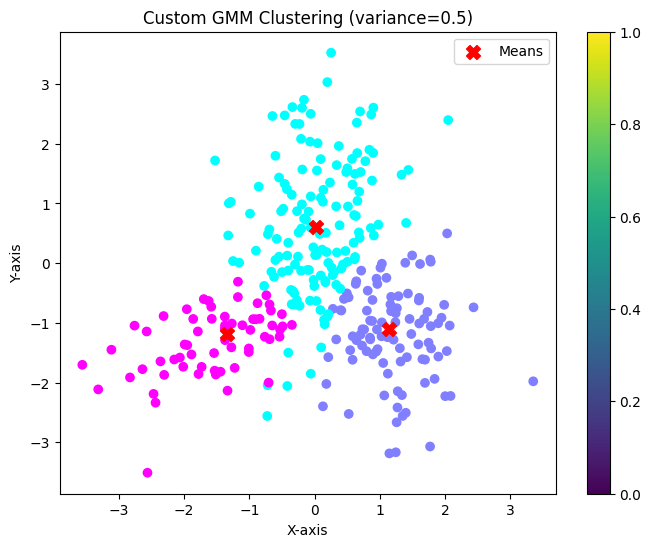

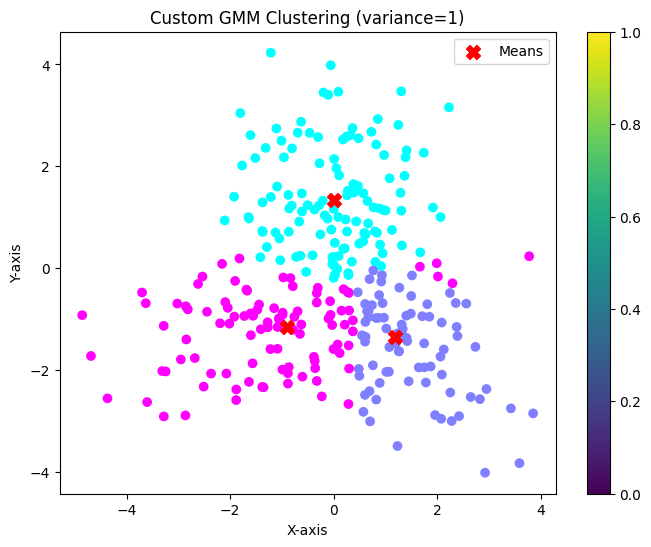

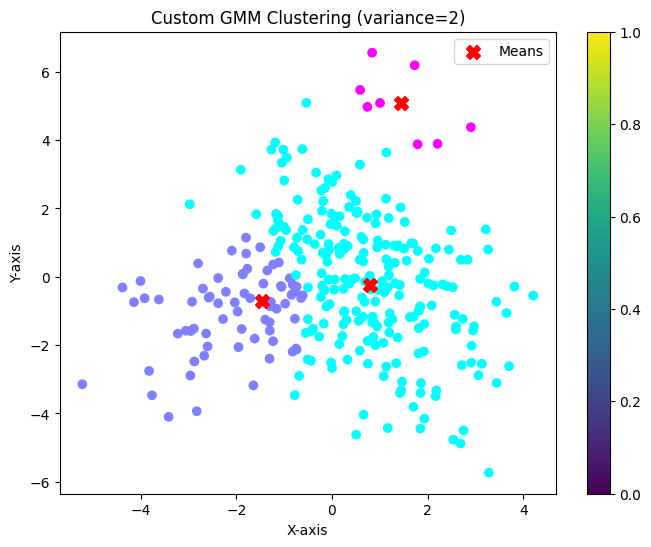

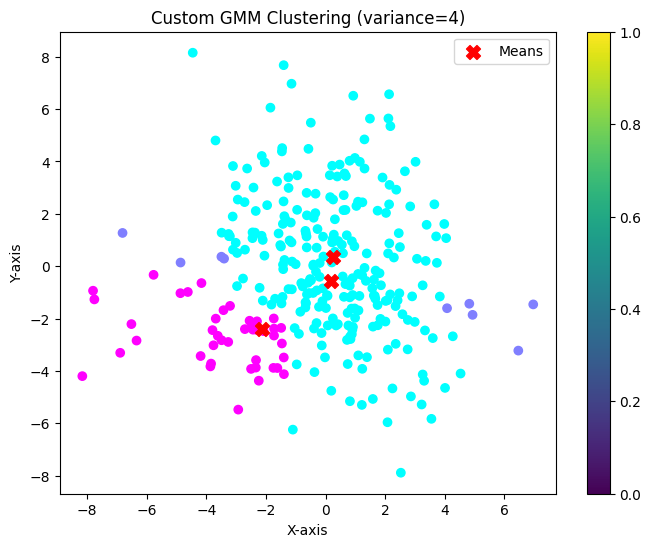

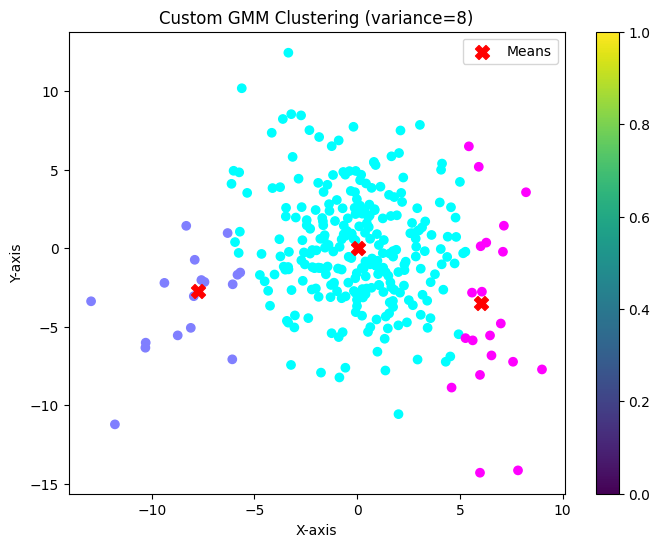

In [65]:
def gmm_objective(data, means, covariances, labels, weights):
    weight_likelihood = np.zeros((len(data), len(means)))
    for i in range(len(means)):
        likelihood = multivariate_normal(means[i], covariances[i]).pdf(data)
        weight_likelihood[:,i] = weights[i] * likelihood
    log_likelihood = -np.sum(np.log(np.sum(weight_likelihood, axis=1)))
    return log_likelihood

def evaluate_custom_gmm_accuracy(true_labels, predicted_labels):
    mapping = {}
    for i in range(len(true_labels)):
        if len(predicted_labels[true_labels == i]) > 0:
            mapping[i] = np.argmax(np.bincount(predicted_labels[true_labels == i]))

    mapped_labels = [mapping[label] for label in predicted_labels if label in mapping]
    accuracy = accuracy_score(true_labels, mapped_labels)
    return accuracy

def plot_custom_clusters_gmm(data, labels, means, covariances, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='cool')
    plt.scatter(means[:, 0], means[:, 1], c='red', s=100, marker='X', label='Means')
    plt.title(title)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.colorbar()
    plt.legend()
    plt.show()

variance_values = [0.5, 1, 2, 4, 8]
custom_datasets = [create_custom_synthetic_data(var, 100) for var in variance_values]

kmeans_objectives = []
gmm_objectives = []
kmeans_accuracies = []
gmm_accuracies = []

letters = ['a', 'b', 'c']
labels = [l for l in letters for i in range(100)]


for i, var in enumerate(variance_values):
    data = custom_datasets[i]
    true_labels = np.repeat(np.arange(3), 100)

    # Custom GMM Clustering
    gmm = GaussianMixtureModel(max_iterations=10000, tolerance=1e-5)
    gmm.cluster(3, data[:, 0], data[:, 1])
    gmm_means = gmm.get_means()
    gmm_covariances = gmm.get_covariances()
    gmm_weights = gmm.get_weights()
    gmm_labels = np.argmax(gmm.get_probabilities(), axis=1)
    #gmm_accuracy = evaluate_custom_gmm_accuracy(true_labels, gmm_labels)
    #gmm_objective_value = gmm_objective(data, gmm_means, gmm_covariances, gmm_labels, gmm_weights)
    gmm_objectives.append(gmm.get_objective_value())
    gmm_accuracies.append(gmm.calculate_accuracy(labels))

    plot_custom_clusters_gmm(data, gmm_labels, gmm_means, gmm_covariances, f'Custom GMM Clustering (variance={var})')





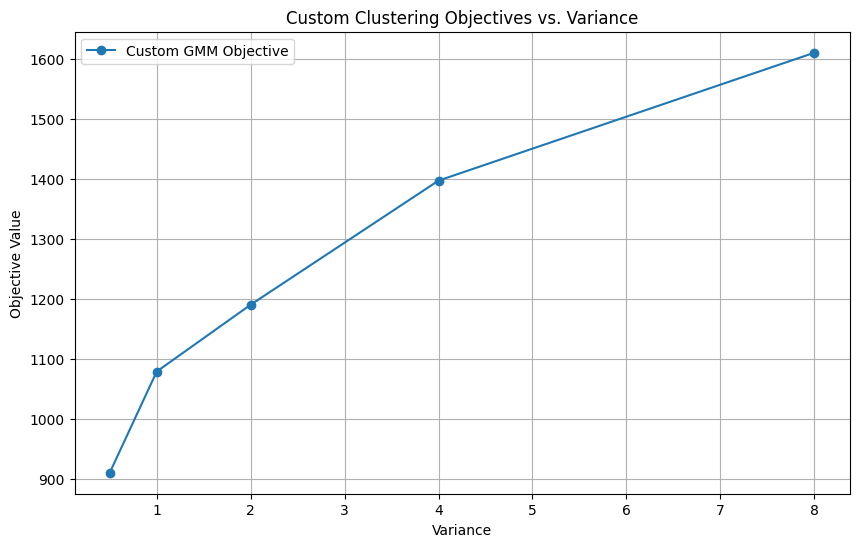

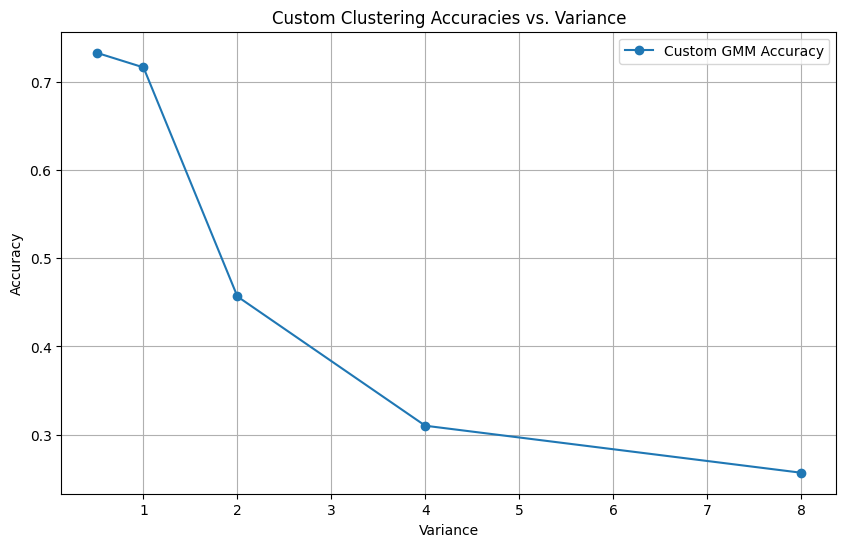

In [66]:
# Plot clustering objectives against variance values for both K-means and GMM
plt.figure(figsize=(10, 6))
plt.plot(variance_values, gmm_objectives, marker='o', label='Custom GMM Objective')
plt.title('Custom Clustering Objectives vs. Variance')
plt.xlabel('Variance')
plt.ylabel('Objective Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot clustering accuracies against variance values for both K-means and GMM
plt.figure(figsize=(10, 6))
plt.plot(variance_values, gmm_accuracies, marker='o', label='Custom GMM Accuracy')
plt.title('Custom Clustering Accuracies vs. Variance')
plt.xlabel('Variance')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


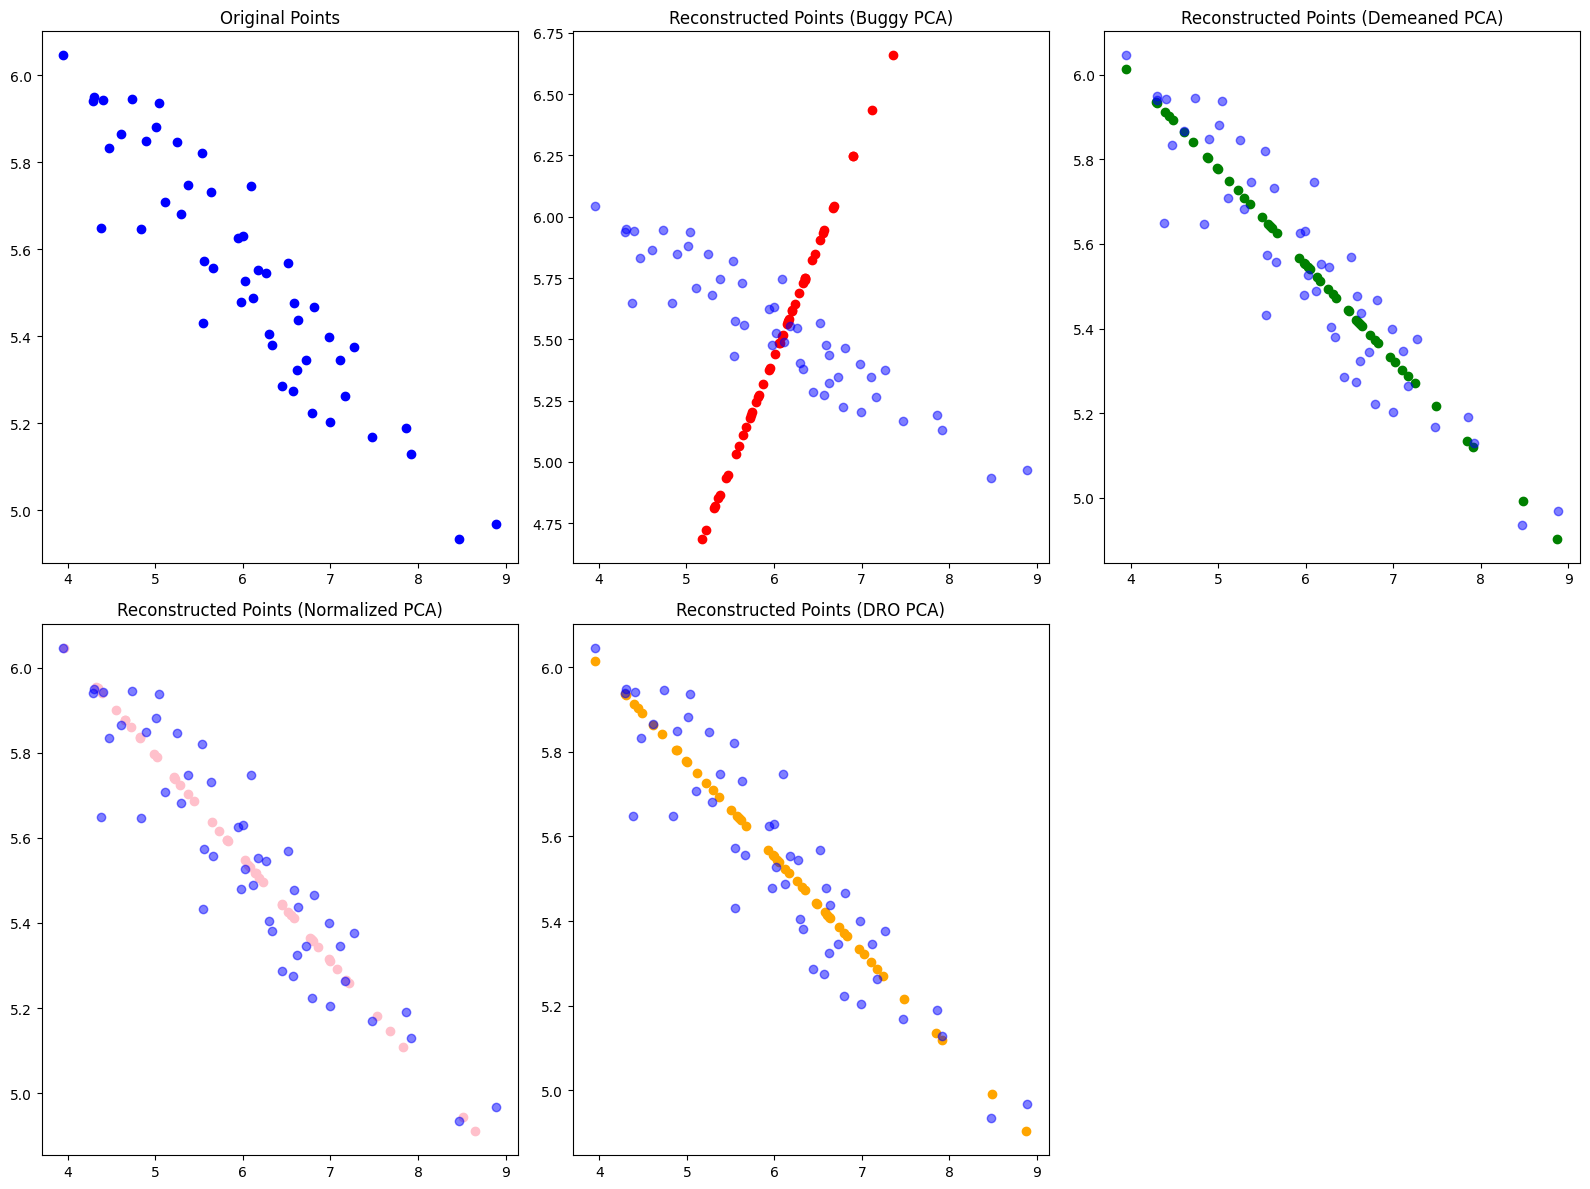

+----------------+----------------------+
|     Method     | Reconstruction Error |
+----------------+----------------------+
|   Buggy PCA    |         0.44         |
|  Demeaned PCA  |         0.01         |
| Normalized PCA |         0.02         |
|    DRO PCA     |         0.01         |
+----------------+----------------------+


In [36]:
import numpy as np
import matplotlib.pyplot as plt


def buggy_PCA(X, d):
    U, S, VT = np.linalg.svd(X,full_matrices=False)
    Z = np.dot(X, VT[:d].T)
    X_reconstructed = np.dot(Z, VT[:d])

    # Calculate reconstruction error (MSE)
    error = np.mean((X - X_reconstructed)**2)

    return X_reconstructed, error

def demeaned_PCA(X, d):
    mean = np.mean(X, axis=0)
    X_demeaned = X - mean
    U, S, VT = np.linalg.svd(X_demeaned)
    Z = np.dot(X_demeaned, VT[:d].T)
    X_reconstructed = np.dot(Z, VT[:d])
    X_reconstructed = X_reconstructed + mean
    # Calculate reconstruction error (MSE)
    error = np.mean((X - X_reconstructed)**2)

    return X_reconstructed, error

def normalized_PCA(X, d):
    mean = np.mean(X, axis=0)
    std_dev = np.std(X, axis=0)
    X_normalized = (X - mean) / std_dev
    U, S, VT = np.linalg.svd(X_normalized)
    Z = np.dot(X_normalized, VT[:d].T)
    X_reconstructed = np.dot(Z, VT[:d])
    X_reconstructed = X_reconstructed*std_dev
    X_reconstructed = X_reconstructed + mean
    # Calculate reconstruction error (MSE)
    error = np.mean((X - X_reconstructed)**2)

    return X_reconstructed, error


def DRO_PCA(X, d):
    mean = np.mean(X, axis=0)
    U, S, VT = np.linalg.svd(X - mean)
    n = len(X)
    Z = np.sqrt(n) * U[:, :d]
    A = np.dot((np.sqrt(1/n) * np.diag(S[:d])), VT[:d]).T
    X_reconstructed = np.dot(Z, A.T) + mean

    # Calculate reconstruction error (MSE)
    error = np.mean((X - X_reconstructed)**2)

    return X_reconstructed, error

def Singular_Values_DRO_PCA(X):
    mean = np.mean(X, axis=0)
    U, S, VT = np.linalg.svd(X - mean)
    return S
# Load the data
data2D = np.loadtxt('./data2D.csv', delimiter=',')

# Perform PCA for each method
X_reconstructed_buggy, error_buggy = buggy_PCA(data2D, d=1)
X_reconstructed_demeaned, error_demeaned = demeaned_PCA(data2D, d=1)
X_reconstructed_normalized, error_normalized = normalized_PCA(data2D, d=1)
X_reconstructed_dro, error_dro = DRO_PCA(data2D, d=1)

# Plot original points and reconstructed points for each method
plt.figure(figsize=(16, 12))

# Original Points
plt.subplot(2, 3, 1)
plt.scatter(data2D[:, 0], data2D[:, 1], c='blue', label='Original Points')
plt.title('Original Points')

# Reconstructed Points (Buggy PCA)
plt.subplot(2, 3, 2)
plt.scatter(X_reconstructed_buggy[:, 0], X_reconstructed_buggy[:, 1], c='red', label='Reconstructed Points')
plt.scatter(data2D[:, 0], data2D[:, 1], c='blue', alpha=0.5)  # Overlay original points
plt.title('Reconstructed Points (Buggy PCA)')

# Reconstructed Points (Demeaned PCA)
plt.subplot(2, 3, 3)
plt.scatter(X_reconstructed_demeaned[:, 0], X_reconstructed_demeaned[:, 1], c='green', label='Reconstructed Points')
plt.scatter(data2D[:, 0], data2D[:, 1], c='blue', alpha=0.5)  # Overlay original points
plt.title('Reconstructed Points (Demeaned PCA)')

# Reconstructed Points (Normalized PCA)
plt.subplot(2, 3, 4)
plt.scatter(X_reconstructed_normalized[:, 0], X_reconstructed_normalized[:, 1], c='pink', label='Reconstructed Points')
plt.scatter(data2D[:, 0], data2D[:, 1], c='blue', alpha=0.5)  # Overlay original points
plt.title('Reconstructed Points (Normalized PCA)')

# Reconstructed Points (Normalized PCA)
plt.subplot(2, 3, 5)
plt.scatter(X_reconstructed_dro[:, 0], X_reconstructed_dro[:, 1], c='orange', label='Reconstructed Points')
plt.scatter(data2D[:, 0], data2D[:, 1], c='blue', alpha=0.5)  # Overlay original points
plt.title('Reconstructed Points (DRO PCA)')


plt.tight_layout()
plt.show()

from tabulate import tabulate

# Assuming you have variables error_buggy, error_demeaned, error_normalized, error_dro

errors = [
    ["Buggy PCA", round(error_buggy,2)],
    ["Demeaned PCA", round(error_demeaned,2)],
    ["Normalized PCA", round(error_normalized,2)],
    ["DRO PCA", round(error_dro,2)]
]

print(tabulate(errors, headers=["Method", "Reconstruction Error"], tablefmt="pretty"))



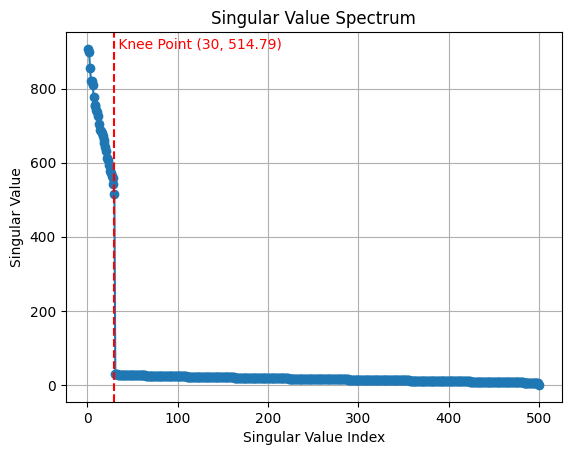

Suggested value of d (knee point): 30


In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data1000D = np.loadtxt('./data1000D.csv', delimiter=',')
singular_values = Singular_Values_DRO_PCA(data1000D)

# Plot the singular values
plt.plot(range(1, len(singular_values)+1), singular_values, marker='o')
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Value')
plt.title('Singular Value Spectrum')
plt.grid(True)

# Find the knee point
diff = np.diff(singular_values)
knee_point = np.argmin(diff) + 1

# Plot the knee point
plt.axvline(x=knee_point, color='red', linestyle='--')
plt.text(knee_point, max(singular_values), f' Knee Point ({knee_point}, {singular_values[knee_point-1]:.2f})', color='red')

# Show the plot
plt.show()

# Print the suggested value of d (knee point)
print(f"Suggested value of d (knee point): {knee_point}")


In [41]:
# Load the data
data1000D = np.loadtxt('./data1000D.csv', delimiter=',')

# Perform PCA for each method
X_reconstructed_buggy, error_buggy = buggy_PCA(data1000D, d=30)
X_reconstructed_demeaned, error_demeaned = demeaned_PCA(data1000D, d=30)
X_reconstructed_normalized, error_normalized = normalized_PCA(data1000D, d=30)
X_reconstructed_dro, error_dro = DRO_PCA(data1000D, d=30)



from tabulate import tabulate

# Assuming you have variables error_buggy, error_demeaned, error_normalized, error_dro

errors = [
    ["Buggy PCA", round(error_buggy,2)],
    ["Demeaned PCA", round(error_demeaned,2)],
    ["Normalized PCA", round(error_normalized,2)],
    ["DRO PCA", round(error_dro,2)]
]

print(tabulate(errors, headers=["Method", "Reconstruction Error"], tablefmt="pretty"))

+----------------+----------------------+
|     Method     | Reconstruction Error |
+----------------+----------------------+
|   Buggy PCA    |         0.8          |
|  Demeaned PCA  |         0.27         |
| Normalized PCA |         0.27         |
|    DRO PCA     |         0.27         |
+----------------+----------------------+
